**Evaluating GOES images with coincident MODIS and ASTER**

What are the magnitude and distribution of differences between ABI-ASTER & MODIS-ASTER?
* Is there an East-to-West change in differences?
* Is there a North-to-South change in differences?
* Is there a relationship between differences and elevation, slope, or aspect?
* Is there a relationship between differences and fractional vegetation covered area?
* Is there a relationship between differences and fractional snow covered area? (from coincident MODIS)

In [1]:
import xarray as xr
from xhistogram.xarray import histogram
import richdem as rd
import rioxarray as rxr
import xrspatial as xrs
import numpy as np
import pandas as pd
import geopandas as gpd
import glob
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

import pysolar
import datetime

from aster_utils import mapZonalStats

from asp_binder_utils import get_dem

/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/osgeo/gdal.py:107: DeprecationWarning: gdal.py was placed in a namespace, it is now available as osgeo.gdal
  DeprecationWarning)


In [2]:
import warnings
warnings.filterwarnings('ignore')

Define functions

In [3]:
def summary_stats(a, b):
    '''Compute summary statistics for the difference between two sets.
    Input two flattened (1-D) arrays with NaN values removed'''
    
    # remove nan values
    a = a[np.isnan(a)==False]
    b = b[np.isnan(b)==False]
    
    # for difference stats
    diff = b - a
    
    # for linear regression stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(a, b)
    
    # populate dict with summary stats
    summary_stats_dict = {
        #'diff' : diff ,
        'n' : len(diff) ,
        'mean_diff' : np.nanmean( diff ),
        'median_diff' : np.nanmedian( diff ),
        'mean_squared_diff' : np.nanmean( diff**2 ),
        'rms_diff' : np.sqrt( np.nanmean( diff**2 ) ),
        'std_diff' : np.nanstd( diff ),
        'slope' : slope,
        'intercept' : intercept,
        'r_value' : r_value,
        'p_value' : p_value,
        'std_err' : std_err
        }
    
    return summary_stats_dict

In [4]:
def plot_regression_confidence_intervals(_x,_y,conf):

    # linear regression
    slope, intercept, r, p, se = stats.linregress(_x, _y)
    
    # predict y values of origional data using the fit
    p_y = slope*_x + intercept
    
    # calculate the y-error (residuals)
    y_err = _y - p_y
    
    # create series of new test x-values to predict for
    p_x = np.arange(np.min(_x),np.max(_x)+1,1)
    
    # now calculate confidence intervals for new test x-series
    mean_x = np.mean(_x)                 # mean of x
    n = _x.size                          # number of samples in original fit
    t = stats.t.ppf(conf, n-2)            # find the appropriate t value (for n-2, and two tailed 95%)        
    sse = np.sum(y_err**2)              # sum of the squares of the residuals
    st_err = np.sqrt(sse/(n-2))         # standard error
    
    sigma = st_err**2 * (1 + 1/n + ( ( n*(p_x-mean_x)**2 ) / ( n*np.sum(_x**2) - np.sum(_x)**2 ) ) )
    confs = t * np.sqrt(sigma)
    
    # now predict y based on test x-values
    p_y = slope*p_x + intercept
    
    # get lower and upper confidence limits based on predicted y and confidence intervals
    lower = p_y - np.abs(confs)
    upper = p_y + np.abs(confs)
    
    # plot line of best fit
    c_x = np.array([_x.min(),_x.max()])
    c_y = slope*c_x + intercept
    plt.plot(c_x,c_y,'r--',label='Regression line')
    
    # plot confidence limits
    plt.plot(p_x,lower,':',c='grey',label='Lower confidence limit (95%)')
    plt.plot(p_x,upper,':',c='grey',label='Upper confidence limit (95%)')

In [5]:
SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


---
## Make dataset

First I need to make a combined dataset to make these investigations easier

OPTIONAL: Read in the ground based data timeseries for Gaylor Pit and CUES sites

In [6]:
## Gaylor Pit
#tuol_df = pd.read_pickle('data/goes-tuolumne_2017-2020.pkl')
#tuol_df['timeUTC'] = tuol_df.index + pd.Timedelta(hours=8)
#tuol_df.set_index('timeUTC',inplace=True)
#tuol_ds = tuol_df.to_xarray().squeeze()
#
## CUES
#cues_df = pd.read_pickle('data/goes-cues_2017-2020.pkl')
#cues_df['timeUTC'] = cues_df.index + pd.Timedelta(hours=8)
#cues_df.set_index('timeUTC',inplace=True)
#cues_ds = cues_df.to_xarray().squeeze()

Set up working area geometry

In [7]:
# Larger area around Tuolumne further south and east to include Mammoth
(utm_e_UL, utm_n_UL) = 282500, 4205000
(utm_e_UR, utm_n_UR) = 305000, 4205000
(utm_e_LR, utm_n_LR) = 327500, 4160000
(utm_e_LL, utm_n_LL) = 305000, 4160000

geometry = [
    {
        'type': 'Polygon',
        'coordinates': [[
            [utm_e_UL, utm_n_UL],
            [utm_e_UR, utm_n_UR],
            [utm_e_LR, utm_n_LR],
            [utm_e_LL, utm_n_LL]
        ]]
    }
]

Find datasets (orthorectified GOES ABI or original GOES ABI)

In [8]:
#filepaths = glob.glob('/storage/spestana/output_ASTER-MODIS-GOES/*_orthorectified.nc')
##filepaths = glob.glob('/storage/spestana/output_ASTER-MODIS-GOES/*_original.nc')

Open all datasets

In [9]:
#ds = xr.open_mfdataset(filepaths, concat_dim='time', combine='nested')
######ds = ds.rio.clip(geometry)

Open my DEM, reproject to UTM, add to the dataset

In [10]:
#dem = xr.open_rasterio('dem/tuolumne_cues_dem.tif').rio.reproject_match(ds)
#ds['dem'] = dem.squeeze()

OLD, skip this: Compute slope and aspect and add to the dataset

In [11]:
#dem_array = rd.rdarray(ds.dem.values, no_data=np.nan).squeeze()
#slope = rd.TerrainAttribute(dem_array, attrib='slope_riserun')
#ds['slope'] = (['y','x'], slope)
#aspect = rd.TerrainAttribute(dem_array, attrib='aspect')
#ds['aspect'] = (['y','x'], aspect)
## aspect looks like it puts 0=360 at East not north. 

---

Create fractional vegetated area from TCC via a binary vegetation map

In [12]:
def fveg_mapZonalStats(zones, zonalstats, stat_name):
    ''' Function for mapping the zonal statistics back to the original grid to get a 2D map of the chosen statistic'''
    # create an empty array for this summary stat
    zonal_stat = np.zeros_like(zones.values, dtype=np.float64)

    # for each zone
    for zone_n in zonalstats.index.values:
        # get the summary stat for that zone, 
        # and assign it to the correct locations in the zonal_stat array
        #try:
        zonal_stat[zones.values==zone_n] = zonalstats['{}'.format(stat_name)].loc[zone_n]
        #except: #MaskError: Cannot convert masked element to a Python int.
        #    zonal_stat[zones.values==zone_n] = -9999

    # convert this to an xarray data array with the proper name
    zonal_stat_da = xr.DataArray(zonal_stat, 
                                 dims=["y", "x"],
                                 coords=dict(
                                             x=(["x"], zones.x),
                                             y=(["y"], zones.y),
                                             ),
                                 name='zonal_{}'.format(stat_name))
    # remove nodata values
    zonal_stat_da = zonal_stat_da.where(zonal_stat_da!=-9999, np.nan)

    return zonal_stat_da     

Open TCC and add to the dataset

In [13]:
#tcc = xr.open_rasterio('data/NLCD_2016_Tree_Canopy_L48_20190831_2xOlzdukUemPqURl8ckP.tiff').rio.reproject_match(ds)
#tcc = tcc.where(tcc!=tcc._FillValue)
#ds['tcc'] = tcc.squeeze()
#

New version: making fveg from binary tcc

In [14]:
#def tcc_to_binary_forest(tcc, threshold):
#    
#    intermediate_map = tcc.where((np.isnan(tcc))|(tcc>threshold),0)
#    
#    binary_forest = intermediate_map.where((np.isnan(intermediate_map))|(intermediate_map<threshold), 1)
#    
#    return binary_forest
#
#ds['binary_tcc_gt10'] = tcc_to_binary_forest(tcc, 10).squeeze()
#ds['binary_tcc_gt20'] = tcc_to_binary_forest(tcc, 20).squeeze()
#ds['binary_tcc_gt30'] = tcc_to_binary_forest(tcc, 30).squeeze()
#ds['binary_tcc_gt40'] = tcc_to_binary_forest(tcc, 40).squeeze()
#ds['binary_tcc_gt50'] = tcc_to_binary_forest(tcc, 50).squeeze()

Plot an image of this if we want to inspect what our choice of threshold did

In [15]:
#fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(40,20))
#[ax1, ax2, ax3, ax4, ax5, ax6] = axs.ravel()
#
#ds.binary_tcc_gt10.where(ds.binary_tcc_gt10!=0).plot(cmap='spring',alpha=1, ax=ax1, add_colorbar=False)
#ds.binary_tcc_gt20.where(ds.binary_tcc_gt20!=0).plot(cmap='spring',alpha=1, ax=ax2, add_colorbar=False)
#ds.binary_tcc_gt30.where(ds.binary_tcc_gt30!=0).plot(cmap='spring',alpha=1, ax=ax3, add_colorbar=False)
#ds.binary_tcc_gt40.where(ds.binary_tcc_gt40!=0).plot(cmap='spring',alpha=1, ax=ax4, add_colorbar=False)
#ds.binary_tcc_gt50.where(ds.binary_tcc_gt50!=0).plot(cmap='spring',alpha=1, ax=ax5, add_colorbar=False)
#
#for ax in  [ax1, ax2, ax3, ax4, ax5]:
#    tcc.plot(ax=ax, cmap='Greys_r', add_colorbar=False, zorder=-99)
#    ax.set_ylim((4.18e6,4.20e6))
#    ax.set_xlim((290000,310000))

I'm going to base my binary forest map on a threshold of 30% TCC

In [16]:
#da_fveg_mean_stack = []
#for i in range(0,len(ds.time)):
#    fveg_mean = ds.isel(time=i).groupby('ast_goes_goes_zones').mean().binary_tcc_gt30.to_dataframe()
#    da_fveg_mean = fveg_mapZonalStats(ds.isel(time=i).ast_goes_goes_zones, fveg_mean, 'binary_tcc_gt30')
#    da_fveg_mean_stack.append(da_fveg_mean)
#    
#ds_fveg_mean = xr.concat(da_fveg_mean_stack, 'time' )
#ds['fveg'] = ds_fveg_mean.where(~np.isnan(ds.ast_goes_goes_zones))

In [17]:
### Old version: Making fveg from tcc mean

###fveg = (tcc - tcc.min()) / (tcc.max() - tcc.min()) # normalizing tcc to get fveg
###ds['fveg'] = fveg.squeeze()
###
###da_fveg_mean_stack = []
###for i in range(0,len(ds.time)):
###    fveg_mean = ds.isel(time=i).groupby('ast_goes_goes_zones').mean().fveg.drop(['spatial_ref','band','time']).to_dataframe()
###    da_fveg_mean = fveg_mapZonalStats(ds.isel(time=i).ast_goes_goes_zones, fveg_mean, 'fveg')
###    da_fveg_mean_stack.append(da_fveg_mean)
###    
###ds_fveg_mean = xr.concat(da_fveg_mean_stack, 'time' )
###ds['zonal_mean_fveg'] = ds_fveg_mean


Save out datafile to a single netcdf

In [18]:
#ds.to_netcdf('/storage/spestana/ASTER-MODIS-GOES-DEM-FVEG_v3_orthorectified.nc')

---
---
## Open dataset (if already created above)

In [19]:
ds = xr.open_dataset('/storage/spestana/ASTER-MODIS-GOES-DEM-FVEG_v3_orthorectified.nc')
ds = ds.rio.clip(geometry)

In [20]:
ds

<xarray.Dataset>
Dimensions:                 (time: 27, x: 499, y: 500)
Coordinates:
  * y                       (y) float64 4.16e+06 4.16e+06 ... 4.205e+06
  * x                       (x) float64 2.826e+05 2.827e+05 ... 3.274e+05
    band                    int64 1
  * time                    (time) datetime64[ns] 2017-04-21T18:51:07 ... 2020-04-13T18:51:17
    spatial_ref             int64 0
Data variables:
    ast_goes_aster_rad      (time, y, x) float64 nan nan nan nan ... nan nan nan
    ast_goes_goes_rad       (time, y, x) float32 nan nan nan nan ... nan nan nan
    ast_goes_goes_tb        (time, y, x) float32 nan nan nan nan ... nan nan nan
    ast_goes_goes_zones     (time, y, x) float64 nan nan nan nan ... nan nan nan
    ast_goes_mean_rad       (time, y, x) float64 nan nan nan nan ... nan nan nan
    ast_goes_max_rad        (time, y, x) float64 nan nan nan nan ... nan nan nan
    ast_goes_min_rad        (time, y, x) float64 nan nan nan nan ... nan nan nan
    ast_goes_std_rad

---




### download another dem to compute slope/aspect/hillshade/etd with

In [21]:
get_dem(demtype='SRTMGL3', 
        bounds=(-120, 36 , -118, 40), 
        out_fn='dem_4.tif')

'dem_4.tif'

In [22]:
dem_elevation = rxr.open_rasterio('dem_4.tif')
dem_elevation = dem_elevation.rio.reproject_match(ds.dem)

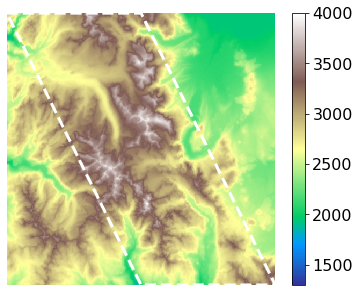

In [23]:
fig, ax = plt.subplots(figsize=(6,5))
dem_elevation.plot(ax=ax, vmin=1300, vmax=4000, cmap='terrain')
ax.axis('off')
ax.set_title('')
ax.plot([utm_e_UL, utm_e_UR, utm_e_LR, utm_e_LL, utm_e_UL],
                 [utm_n_UL, utm_n_UR, utm_n_LR, utm_n_LL, utm_n_UL],
                 linestyle='--', color='w', lw=3)

Compute Aspect Map

In [24]:
!gdaldem aspect dem_4.tif aspect_4.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


In [25]:
dem_aspect = rxr.open_rasterio('aspect_4.tif')
dem_aspect = dem_aspect.rio.reproject_match(ds.dem)
dem_aspect = dem_aspect.where(dem_aspect != -9999)

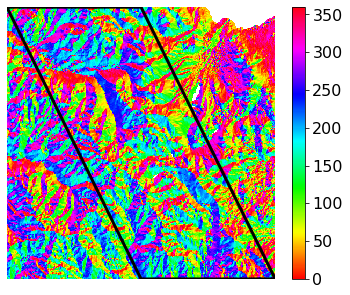

In [26]:
fig, ax = plt.subplots(figsize=(6,5))
dem_aspect.plot(ax=ax, cmap='hsv')
ax.axis('off')
ax.set_title('')
ax.plot([utm_e_UL, utm_e_UR, utm_e_LR, utm_e_LL, utm_e_UL],
                 [utm_n_UL, utm_n_UR, utm_n_LR, utm_n_LL, utm_n_UL],
                 linestyle='-', color='k', lw=3)

Add aspect to dataset

In [27]:
ds['dem_aspect'] = dem_aspect.squeeze()

Compute Slope Map (need to reproject first into UTM so we compute vertical meters / horizontal meters)

In [28]:
!gdalwarp -t_srs EPSG:32611 dem_4.tif dem_4utm.tif

Processing dem_4.tif [1/1] : 0Using internal nodata values (e.g. 0) for image dem_4.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


In [29]:
!gdaldem slope dem_4utm.tif slope_4.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


In [30]:
dem_slope = rxr.open_rasterio('slope_4.tif')
dem_slope = dem_slope.rio.reproject_match(ds.dem)
dem_slope = dem_slope.where(dem_slope != -9999.) 
#dem_slope = dem_slope.where(dem_slope != -9999)
#dem_slope = dem_slope.where(dem_slope != 0)

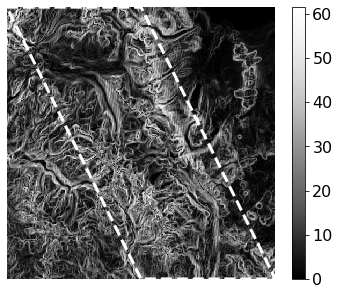

In [31]:
fig, ax = plt.subplots(figsize=(6,5))
dem_slope.plot(ax=ax, cmap='Greys_r')
ax.axis('off')
ax.set_title('')
ax.plot([utm_e_UL, utm_e_UR, utm_e_LR, utm_e_LL, utm_e_UL],
                 [utm_n_UL, utm_n_UR, utm_n_LR, utm_n_LL, utm_n_UL],
                 linestyle='--', color='w', lw=3)

Add slope to dataset

In [32]:
ds['dem_slope'] = dem_slope.squeeze()

---
Hillshade function

In [33]:
def hillshade(slope, aspect, zenith, azimuth):
    slope_rad = np.radians(slope)
    aspect_rad = np.radians(aspect)
    zenith_rad = np.radians(zenith)
    azimuth_rad = np.radians(azimuth)
    hillshade = np.cos(zenith_rad)*np.cos(slope_rad) + np.sin(zenith_rad)*np.sin(slope_rad)*np.cos(azimuth_rad - aspect_rad)
    return hillshade

### Test hillshade function
#_slopes = np.array([np.arange(0,90,1)]*360).T
#_aspects = np.array([np.arange(0,360,1)]*90)
#
#test_hs = hillshade(_slopes, _aspects, 45, 90)
#
#plt.pcolormesh(test_hs,vmin=-1,vmax=1,cmap='RdBu_r')
#plt.colorbar(label='hillshade')
#plt.ylabel('slope')
#plt.xlabel('aspect')

Function for computing GOES Local Zenith Angles, and Azimuth

In [34]:
def goes_lza(lat_ssp, lon_ssp, lat, lon, H=42164.16, r_eq=6378.137):
    
    '''
    Compute the Locan Zenith Angle for a point on Earth surface to a GOES-R geostationary satellite.
        See more details from NOAA here: 
        https://www.ncdc.noaa.gov/sites/default/files/attachments/GOES-R_ABI_local_zenith_angle_description.docx
    
    Inputs:
        GOES-R satellite position
            lat_ssp: sub-satellite point latitude [degrees]
            lon_ssp: sub-satellite point longitude [degrees]
    
        View point (on Earth's surface) position
            lat: view point latitude on Earth's surfaace [degrees]
            lon: view point longitude on Earth's surface [degrees]
            elev: view point elevation (heigh above GRS80 ellispoid) [km]
            
        Earth model parameters (optional)
            H: satellite distance to Earth center [km] (defaults to 42164.16 km)
            r_eq: Earth semi-major axis (GRS80 ellipsoid) [km] (defaults to 6378.137 km)
            
    Returns:
        LZA: local zenith angle [degrees]
        is_point_visible: True/False flag indicating if the ground point is actually visible to the satellite
    
    '''

    # intermediate calculation
    B = np.arccos( np.cos(np.radians(lat)-np.radians(lat_ssp)) * np.cos(np.radians(lon)-np.radians(lon_ssp)) )

    # determine if point is visible to the satellite
    is_point_visible = (B < np.arccos(r_eq / (H+r_eq)))

    # compute LZA
    LZA_radians = np.arcsin( (H * np.sin(B) ) / ( np.sqrt( H**2 + r_eq**2 - 2*H*r_eq*np.cos(B) ) ) )
    
    # convert LZA from radians to degrees
    LZA = LZA_radians * 180/np.pi
    
    return LZA, is_point_visible




def goes_azi(lat_ssp, lon_ssp, lat, lon):
    
    '''quick calculation of azimuth for geostationary satellite, not GOES specific, spherical Earth assumption
    http://tiij.org/issues/issues/3_2/3_2e.html'''
    
    azi = 180 + np.degrees( np.arctan(np.tan(np.radians(lon_ssp - lon))/np.sin(np.radians(lat))) )
    
    return azi.T



def diurnal_anisotropic_heat(aspect, slope, a_max):
    '''
    Make a Diurnal Anisotropic Heating (DAH) index (Böhner & Antonic, 2009)
        a_max = 202.5 (SSW) from Cristea et al., 2017 in Tuolumne area
    '''
    DAH = np.cos(np.radians(a_max - aspect)) * np.arctan(np.radians(slope))
    return DAH

Compute LZA and Azimuth maps

In [36]:
dem_latlon = rxr.open_rasterio('dem_4.tif')

# when t is 0,1,2,3,4... ssp_lon = -89.5

# for satellite+terrain geometry maps
list_of_satellite_lza_maps = []
list_of_satellite_azi_maps = []
list_of_satellite_hillshade_maps = []

# for solar+terrain geometry maps
list_of_solar_lza_maps = []
list_of_solar_azi_maps = []
list_of_solar_hillshade_maps = []
list_of_dah_maps = []

for t_idx, this_t in enumerate(ds.time):
    
    lat_ssp = 0 # on the equator
    
    # first 5 observations GOES-16 was in the -89.5 "test" orbital slot, thereafter at -75.2 lon
    if t_idx <= 4:
        lon_ssp = -89.5
    else:
        lon_ssp = -75.2
    
    # make satellite local zenith angle map
    this_lza_map, this_visible = goes_lza(lat_ssp, lon_ssp, dem_latlon.y, dem_latlon.x)
    this_lza_map = this_lza_map.rio.reproject_match(ds.dem)
    list_of_satellite_lza_maps.append(this_lza_map.squeeze())
    
    # make satellite azimuth angle map
    this_azi_map = goes_azi(lat_ssp, -lon_ssp, dem_latlon.y, -dem_latlon.x) # right now this counts positive in the west direction
    this_azi_map = this_azi_map.rio.reproject_match(ds.dem)
    list_of_satellite_azi_maps.append(this_azi_map.squeeze())
    
    # make satellite hillshade map
    this_sat_hillshade_map = hillshade(ds.dem_slope, ds.dem_aspect, this_lza_map, this_azi_map)
    list_of_satellite_hillshade_maps.append(this_sat_hillshade_map.squeeze())
    
    # do np.datetime64 -> datetime.datetime conversion for solar maps
    this_datetime = pd.Timestamp( this_t.values, tzinfo=datetime.timezone.utc )

    # make solar local zenith angle map
    solar_altitude_deg = pysolar.solar.get_altitude(dem_latlon.y, dem_latlon.x, this_datetime).transpose('y', 'x')
    solar_altitude_deg = solar_altitude_deg.rio.reproject_match(ds.dem)
    solar_lza_deg = 90 - solar_altitude_deg # subtract 90 degrees from elevation angle to get zenith angle
    list_of_solar_lza_maps.append(solar_lza_deg.squeeze())
    
    # make solar azimuth angle map
    solar_azimuth_deg = pysolar.solar.get_azimuth(dem_latlon.y, dem_latlon.x, this_datetime).transpose('y', 'x')
    solar_azimuth_deg = solar_azimuth_deg.rio.reproject_match(ds.dem)
    list_of_solar_azi_maps.append(solar_azimuth_deg.squeeze())
    
    # make solar hillshade map
    this_solar_hillshade_map = hillshade(ds.dem_slope, ds.dem_aspect, solar_lza_deg, solar_azimuth_deg)
    list_of_solar_hillshade_maps.append(this_solar_hillshade_map.squeeze())
    
    # make Diurnal Anisotropic Heating index map
    this_DAH = diurnal_anisotropic_heat(ds.dem_aspect, ds.dem_slope, solar_azimuth_deg)
    list_of_dah_maps.append(this_DAH.squeeze())

Add all these satellite and solar LZA, Azi, Hillshade, and DAH maps to our dataset

In [37]:
# satellite
ds['sat_azimuth'] = xr.concat(list_of_satellite_azi_maps, 'time')
ds['sat_lza'] = xr.concat(list_of_satellite_lza_maps, 'time')
ds['sat_hillshade'] = xr.concat(list_of_satellite_hillshade_maps, 'time')

# solar
ds['solar_azimuth'] = xr.concat(list_of_solar_azi_maps, 'time')
ds['solar_lza'] = xr.concat(list_of_solar_lza_maps, 'time')
ds['solar_hillshade'] = xr.concat(list_of_solar_hillshade_maps, 'time')
ds['DAH'] = xr.concat(list_of_dah_maps, 'time')

Make zonal mean maps of hillshades and DAH

In [40]:
# for zonal mean satellite+terrain geometry maps
list_of_zonal_mean_satellite_hillshade_maps = []

# for zonal mean solar+terrain geometry maps
list_of_zonal_mean_solar_hillshade_maps = []
list_of_zonal_mean_dah_maps = []

for t_idx, this_t in enumerate(ds.time):
    
    zonal_mean_sat_hillshade = ds.isel(time=t_idx).groupby('ast_goes_goes_zones').mean().sat_hillshade.to_dataframe()
    da_zonal_mean_sat_hillshade = fveg_mapZonalStats(ds.isel(time=t_idx).ast_goes_goes_zones, zonal_mean_sat_hillshade, 'sat_hillshade')
    list_of_zonal_mean_satellite_hillshade_maps.append(da_zonal_mean_sat_hillshade)
    
    zonal_mean_solar_hillshade = ds.isel(time=t_idx).groupby('ast_goes_goes_zones').mean().solar_hillshade.to_dataframe()
    da_zonal_mean_solar_hillshade = fveg_mapZonalStats(ds.isel(time=t_idx).ast_goes_goes_zones, zonal_mean_solar_hillshade, 'solar_hillshade')
    list_of_zonal_mean_solar_hillshade_maps.append(da_zonal_mean_solar_hillshade)
    
    zonal_mean_dah = ds.isel(time=t_idx).groupby('ast_goes_goes_zones').mean().DAH.to_dataframe()
    da_zonal_mean_dah = fveg_mapZonalStats(ds.isel(time=t_idx).ast_goes_goes_zones, zonal_mean_dah, 'DAH')
    list_of_zonal_mean_dah_maps.append(da_zonal_mean_dah)
    
#ds_fveg_mean = xr.concat(da_fveg_mean_stack, 'time' )
#ds['fveg'] = ds_fveg_mean.where(~np.isnan(ds.ast_goes_goes_zones))

Add these to the dataset

In [41]:
ds['sat_hillshade_goes_zonal_mean'] = xr.concat(list_of_zonal_mean_satellite_hillshade_maps, 'time')
ds['solar_hillshade_goes_zonal_mean'] = xr.concat(list_of_zonal_mean_solar_hillshade_maps, 'time')
ds['DAH_goes_zonal_mean'] = xr.concat(list_of_zonal_mean_dah_maps, 'time')

In [42]:
# save this version out
ds.to_netcdf('/storage/spestana/ASTER-MODIS-GOES-DEM-FVEG_v4_orthorectified.nc')

---
---
---

In [ ]:
# This is just an example, or to make an illustrative plot of GOES ABI LZA and Azimuth

#dem_latlon = rxr.open_rasterio('dem_4.tif') # need to open the dem in its WGS84 lat/lon projection
#lza_map, visible = goes_lza(0, -75.2, dem_latlon.y, dem_latlon.x)
#lza_map = lza_map.rio.reproject_match(ds.dem)
#
#azimuth_map = goes_azi(0, 75.2, dem_latlon.y, -dem_latlon.x)
#azimuth_map = azimuth_map.rio.reproject_match(ds.dem)
#
#
#fig, ax = plt.subplots(figsize=(6,5))
#lza_map.plot(ax=ax)
#ax.axis('off')
#ax.set_title(f'mean LZA = {np.round(np.mean(lza_map).values,2)}')
#ax.plot([utm_e_UL, utm_e_UR, utm_e_LR, utm_e_LL, utm_e_UL],
#                 [utm_n_UL, utm_n_UR, utm_n_LR, utm_n_LL, utm_n_UL],
#                 linestyle='--', color='w', lw=3)
#
#fig, ax = plt.subplots(figsize=(6,5))
#azimuth_map.plot(ax=ax)
#ax.axis('off')
#ax.set_title(f'mean AZI = {np.round(np.mean(azimuth_map).values,2)}')
#ax.plot([utm_e_UL, utm_e_UR, utm_e_LR, utm_e_LL, utm_e_UL],
#                 [utm_n_UL, utm_n_UR, utm_n_LR, utm_n_LL, utm_n_UL],
#                 linestyle='--', color='w', lw=3)

### Compute two hillshades
* **hs_sat** for the satellite's view
* **hs_sun** for solar illumination

In [ ]:
#hs_sat = hillshade(dem_slope, dem_aspect, lza_map, azimuth_map)
#hs_sat = hs_sat.rio.clip(geometry)

In [ ]:
#fig, ax = plt.subplots(figsize=(6,5))
#hs_sat.plot(cmap='Greys_r',vmin=0,vmax=1,ax=ax,alpha=1)
#ax.axis('off')
#ax.set_title('')
#ax.plot([utm_e_UL, utm_e_UR, utm_e_LR, utm_e_LL, utm_e_UL],
#                 [utm_n_UL, utm_n_UR, utm_n_LR, utm_n_LL, utm_n_UL],
#                 linestyle='-', color='k', lw=3);
#
#fig, ax = plt.subplots(figsize=(6,5))
#hs_sat.plot(cmap='Greys_r',vmin=0,vmax=1,ax=ax,alpha=1)
#hs_sat.where(hs_sat<=0).plot(cmap='spring',vmin=0,vmax=1,ax=ax,alpha=1, add_colorbar=False)
#ax.axis('off')
#ax.set_title('')
#ax.plot([utm_e_UL, utm_e_UR, utm_e_LR, utm_e_LL, utm_e_UL],
#                 [utm_n_UL, utm_n_UR, utm_n_LR, utm_n_LL, utm_n_UL],
#                 linestyle='-', color='k', lw=3);

---

### Sunlight hillshade maps
* use pysolar to get sun positions for each DEM gridcell for each of the 27 date/times of GOES observations

In [ ]:
##date = datetime.datetime(2007, 2, 18, 18, 59, 59, tzinfo=datetime.timezone.utc)
#dates = [pd.Timestamp( this_date, tzinfo=datetime.timezone.utc ) for this_date in ds.time.values]
#date = dates[1]
#
#longitude = dem_latlon.x
#latitude = dem_latlon.y

In [ ]:
#solar_altitude_deg = pysolar.solar.get_altitude(latitude, longitude, date).transpose('y', 'x')
#solar_altitude_deg = solar_altitude_deg.rio.reproject_match(ds.dem)
#solar_lza_deg = 90 - solar_altitude_deg
##.rio.clip(geometry)
#
#solar_azimuth_deg = pysolar.solar.get_azimuth(latitude, longitude, date).transpose('y', 'x')
#solar_azimuth_deg = azimuth_deg.rio.reproject_match(ds.dem)
##.rio.clip(geometry)

In [ ]:
#fig, ax = plt.subplots(figsize=(6,5))
#solar_lza_deg.plot(ax=ax,alpha=1)
#ax.axis('off')
#ax.set_title(f'Solar LZA {date}')
#ax.plot([utm_e_UL, utm_e_UR, utm_e_LR, utm_e_LL, utm_e_UL],
#                 [utm_n_UL, utm_n_UR, utm_n_LR, utm_n_LL, utm_n_UL],
#                 linestyle='--', color='w', lw=3);
#
#fig, ax = plt.subplots(figsize=(6,5))
#solar_azimuth_deg.plot(ax=ax,alpha=1)
#ax.axis('off')
#ax.set_title(f'Solar Azimuth {date}')
#ax.plot([utm_e_UL, utm_e_UR, utm_e_LR, utm_e_LL, utm_e_UL],
#                 [utm_n_UL, utm_n_UR, utm_n_LR, utm_n_LL, utm_n_UL],
#                 linestyle='--', color='w', lw=3);

Compute solar hillshade for date/time

In [ ]:
#hs_sun = hillshade(dem_slope, dem_aspect, solar_lza_deg, solar_azimuth_deg)
#hs_sun = hs_sun.rio.clip(geometry)

In [ ]:
#fig, ax = plt.subplots(figsize=(6,5))
#hs_sun.plot(cmap='Greys_r',vmin=0,vmax=1,ax=ax,alpha=1)
#hs_sun.where(hs_sun<=0).plot(cmap='spring',vmin=0,vmax=1,ax=ax,alpha=1, add_colorbar=False)
#ax.axis('off')
#ax.set_title('')
#ax.plot([utm_e_UL, utm_e_UR, utm_e_LR, utm_e_LL, utm_e_UL],
#                 [utm_n_UL, utm_n_UR, utm_n_LR, utm_n_LL, utm_n_UL],
#                 linestyle='-', color='k', lw=3);

Make a Diurnal Anisotropic Heating index 
* DAH from (Böhner & Antonic, 2009)
* $\alpha_{max} = 202.5^o (SSW)$ from Cristea et al., 2017 in Tuolumne area

In [ ]:
#DAH = diurnal_anisotropic_heat(dem_aspect, dem_slope, solar_azimuth_deg)

In [ ]:
#fig, ax = plt.subplots(figsize=(6,5))
#DAH.plot(ax=ax,alpha=1)
#ax.axis('off')
#ax.set_title(f'DAH')
#ax.plot([utm_e_UL, utm_e_UR, utm_e_LR, utm_e_LL, utm_e_UL],
#                 [utm_n_UL, utm_n_UR, utm_n_LR, utm_n_LL, utm_n_UL],
#                 linestyle='-', color='k', lw=3);